# 短文・長文混合による超平面学習の検証

## 目的

Notebook 15で判明した問題（短文クエリでの低Recall）を解決するため、
**英語データのみ**で短文・長文を混合した超平面を学習し、
日本語・英語、未知の検索ワードで評価する。

## 仮説

- 長文のみで学習した超平面は、短文には効果が薄い
- 短文・長文を混合して学習すれば、両方に効果的な超平面が得られる

## 実験設計

### 超平面の学習パターン

| パターン | 学習データ | サンプル数 |
|----------|-----------|------------|
| A | 英語本文のみ (body_en) | 300 |
| B | 英語タイトルのみ (titles_en) | 300 |
| C | 英語混合 (body_en + titles_en) | 300 (150+150) |
| D | 英語混合 (body_en + titles_en) | 1000 (500+500) |

### 評価

1. 日本語・英語の各データセット内検索
2. 外部検索ワード（30件）での全体検索

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import duckdb
from tqdm import tqdm
import time

from src.lsh import (
    SimHashGenerator, 
    hamming_distance,
    generate_data_sampled_hyperplanes
)

## 1. データの読み込み

In [3]:
# DuckDBに接続
con = duckdb.connect('../data/experiment_400k.duckdb', read_only=True)

# データ件数を確認
result = con.execute("SELECT dataset, COUNT(*) as cnt FROM documents GROUP BY dataset ORDER BY dataset").fetchall()
print('データセット別件数:')
for dataset, cnt in result:
    print(f'  {dataset}: {cnt:,}件')

total = con.execute("SELECT COUNT(*) FROM documents").fetchone()[0]
print(f'\n合計: {total:,}件')

データセット別件数:
  body_en: 100,000件
  body_ja: 100,000件
  titles_en: 100,000件
  titles_ja: 100,000件

合計: 400,000件


In [4]:
# 全データを読み込み
print('データ読み込み中...')

datasets = ['body_en', 'body_ja', 'titles_en', 'titles_ja']
all_embeddings = {}
all_ids = {}

for dataset in tqdm(datasets, desc='データセット'):
    df = con.execute(f"""
        SELECT id, embedding 
        FROM documents 
        WHERE dataset = '{dataset}'
        ORDER BY id
    """).fetchdf()
    
    embeddings = np.array(df['embedding'].tolist(), dtype=np.float32)
    ids = df['id'].values
    
    all_embeddings[dataset] = embeddings
    all_ids[dataset] = ids
    
    print(f'  {dataset}: {len(embeddings):,}件')

print('\n読み込み完了')

データ読み込み中...


データセット:  25%|██▌       | 1/4 [00:01<00:03,  1.15s/it]

  body_en: 100,000件


データセット:  50%|█████     | 2/4 [00:02<00:02,  1.16s/it]

  body_ja: 100,000件


データセット:  75%|███████▌  | 3/4 [00:03<00:01,  1.32s/it]

  titles_en: 100,000件


データセット: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

  titles_ja: 100,000件

読み込み完了


## 2. 超平面の学習（4パターン）

In [5]:
# 超平面学習用の関数
def create_hyperplanes_from_datasets(
    embeddings_dict: dict,
    dataset_samples: dict,  # {dataset_name: num_samples}
    hash_bits: int = 128,
    seed: int = 42
) -> np.ndarray:
    """
    複数のデータセットから指定数ずつサンプリングして超平面を生成
    
    Args:
        embeddings_dict: {dataset_name: embeddings}
        dataset_samples: {dataset_name: num_samples}
        hash_bits: ハッシュビット数
        seed: 乱数シード
    
    Returns:
        超平面 (hash_bits, dim)
    """
    rng = np.random.default_rng(seed)
    
    # 各データセットからサンプリング
    sampled_embeddings = []
    for dataset_name, num_samples in dataset_samples.items():
        embeddings = embeddings_dict[dataset_name]
        indices = rng.choice(len(embeddings), num_samples, replace=False)
        sampled_embeddings.append(embeddings[indices])
        print(f'  {dataset_name}: {num_samples}件サンプリング')
    
    # 統合
    combined = np.vstack(sampled_embeddings)
    print(f'  合計: {len(combined)}件')
    
    # 超平面を生成
    hyperplanes = generate_data_sampled_hyperplanes(combined, hash_bits, seed=seed)
    
    return hyperplanes

In [6]:
# パターンA: 英語本文のみ 300件
print('=' * 80)
print('パターンA: 英語本文のみ (body_en) 300件')
print('=' * 80)

hyperplanes_A = create_hyperplanes_from_datasets(
    all_embeddings,
    {'body_en': 300},
    seed=42
)
print(f'超平面の形状: {hyperplanes_A.shape}')

パターンA: 英語本文のみ (body_en) 300件
  body_en: 300件サンプリング
  合計: 300件
超平面の形状: (128, 1024)


In [7]:
# パターンB: 英語タイトルのみ 300件
print('=' * 80)
print('パターンB: 英語タイトルのみ (titles_en) 300件')
print('=' * 80)

hyperplanes_B = create_hyperplanes_from_datasets(
    all_embeddings,
    {'titles_en': 300},
    seed=42
)
print(f'超平面の形状: {hyperplanes_B.shape}')

パターンB: 英語タイトルのみ (titles_en) 300件
  titles_en: 300件サンプリング
  合計: 300件
超平面の形状: (128, 1024)


In [8]:
# パターンC: 英語混合 300件 (本文150 + タイトル150)
print('=' * 80)
print('パターンC: 英語混合 300件 (body_en 150 + titles_en 150)')
print('=' * 80)

hyperplanes_C = create_hyperplanes_from_datasets(
    all_embeddings,
    {'body_en': 150, 'titles_en': 150},
    seed=42
)
print(f'超平面の形状: {hyperplanes_C.shape}')

パターンC: 英語混合 300件 (body_en 150 + titles_en 150)
  body_en: 150件サンプリング
  titles_en: 150件サンプリング
  合計: 300件
超平面の形状: (128, 1024)


In [9]:
# パターンD: 英語混合 1000件 (本文500 + タイトル500)
print('=' * 80)
print('パターンD: 英語混合 1000件 (body_en 500 + titles_en 500)')
print('=' * 80)

hyperplanes_D = create_hyperplanes_from_datasets(
    all_embeddings,
    {'body_en': 500, 'titles_en': 500},
    seed=42
)
print(f'超平面の形状: {hyperplanes_D.shape}')

パターンD: 英語混合 1000件 (body_en 500 + titles_en 500)
  body_en: 500件サンプリング
  titles_en: 500件サンプリング
  合計: 1000件
超平面の形状: (128, 1024)


In [10]:
# 超平面をまとめる
hyperplanes_patterns = {
    'A_body_en_300': hyperplanes_A,
    'B_titles_en_300': hyperplanes_B,
    'C_mixed_en_300': hyperplanes_C,
    'D_mixed_en_1000': hyperplanes_D,
}

print('\n超平面パターン:')
for name, hp in hyperplanes_patterns.items():
    print(f'  {name}: {hp.shape}')


超平面パターン:
  A_body_en_300: (128, 1024)
  B_titles_en_300: (128, 1024)
  C_mixed_en_300: (128, 1024)
  D_mixed_en_1000: (128, 1024)


## 3. 各パターンでSimHashを計算

In [11]:
def compute_hashes_with_hyperplanes(embeddings_dict, hyperplanes):
    """指定した超平面で全データのSimHashを計算"""
    gen = SimHashGenerator(dim=1024, hash_bits=128, seed=0, strategy='random')
    gen.hyperplanes = hyperplanes
    
    hashes = {}
    for dataset, embeddings in embeddings_dict.items():
        hashes[dataset] = gen.hash_batch(embeddings)
    
    return hashes, gen

In [12]:
# 各パターンでハッシュを計算
print('SimHash計算中...')

all_hashes_by_pattern = {}
generators = {}

for pattern_name, hyperplanes in tqdm(hyperplanes_patterns.items(), desc='パターン'):
    hashes, gen = compute_hashes_with_hyperplanes(all_embeddings, hyperplanes)
    all_hashes_by_pattern[pattern_name] = hashes
    generators[pattern_name] = gen
    print(f'  {pattern_name}: 完了')

print('\n完了')

SimHash計算中...


パターン:  25%|██▌       | 1/4 [00:04<00:13,  4.62s/it]

  A_body_en_300: 完了


パターン:  50%|█████     | 2/4 [00:09<00:09,  4.64s/it]

  B_titles_en_300: 完了


パターン:  75%|███████▌  | 3/4 [00:13<00:04,  4.63s/it]

  C_mixed_en_300: 完了


パターン: 100%|██████████| 4/4 [00:18<00:00,  4.64s/it]

  D_mixed_en_1000: 完了

完了


## 4. 評価1: データセット内検索（Recall@10）

In [13]:
def evaluate_recall_within_dataset(
    embeddings: np.ndarray,
    hashes: list,
    num_queries: int = 25,
    candidate_limit: int = 1000,
    top_k: int = 10,
    seed: int = 42
) -> float:
    """データセット内でのRecall@kを評価"""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    query_indices = rng.choice(n, num_queries, replace=False)
    
    recalls = []
    for q_idx in query_indices:
        query_vec = embeddings[q_idx]
        query_hash = hashes[q_idx]
        
        # Ground Truth
        cos_sims = embeddings @ query_vec
        gt_top_k = set(np.argsort(cos_sims)[::-1][:top_k])
        
        # LSH候補
        distances = [(i, hamming_distance(h, query_hash)) for i, h in enumerate(hashes)]
        distances.sort(key=lambda x: x[1])
        candidates = set(idx for idx, _ in distances[:candidate_limit])
        
        recall = len(gt_top_k & candidates) / top_k
        recalls.append(recall)
    
    return np.mean(recalls)

In [14]:
# 全パターン × 全データセットでRecallを評価
print('データセット内検索のRecall評価')
print('=' * 100)

candidate_limit = 1000  # 10万件中1000件 = 1%
results_within = []

for pattern_name in hyperplanes_patterns.keys():
    hashes = all_hashes_by_pattern[pattern_name]
    
    for dataset in datasets:
        recall = evaluate_recall_within_dataset(
            all_embeddings[dataset],
            hashes[dataset],
            num_queries=25,
            candidate_limit=candidate_limit,
            seed=42
        )
        results_within.append({
            'pattern': pattern_name,
            'dataset': dataset,
            'recall': recall
        })

df_within = pd.DataFrame(results_within)
print('完了')

データセット内検索のRecall評価
完了


In [15]:
# ピボットテーブルで表示
pivot_within = df_within.pivot(index='pattern', columns='dataset', values='recall')
pivot_within = pivot_within[['body_en', 'body_ja', 'titles_en', 'titles_ja']]
pivot_within['平均'] = pivot_within.mean(axis=1)

print('=' * 100)
print(f'データセット内検索 Recall@10（候補{candidate_limit:,}件 = 1%）')
print('=' * 100)
print()

print(f'{"パターン":>20} | {"body_en":>10} | {"body_ja":>10} | {"titles_en":>10} | {"titles_ja":>10} | {"平均":>10}')
print('-' * 90)

for pattern in hyperplanes_patterns.keys():
    row = pivot_within.loc[pattern]
    print(f'{pattern:>20} | {row["body_en"]:>10.1%} | {row["body_ja"]:>10.1%} | {row["titles_en"]:>10.1%} | {row["titles_ja"]:>10.1%} | {row["平均"]:>10.1%}')

データセット内検索 Recall@10（候補1,000件 = 1%）

                パターン |    body_en |    body_ja |  titles_en |  titles_ja |         平均
------------------------------------------------------------------------------------------
       A_body_en_300 |      71.2% |      71.2% |      57.2% |      66.8% |      66.6%
     B_titles_en_300 |      66.4% |      54.8% |      57.6% |      62.4% |      60.3%
      C_mixed_en_300 |      69.6% |      64.0% |      56.8% |      58.0% |      62.1%
     D_mixed_en_1000 |      67.6% |      59.6% |      56.0% |      57.6% |      60.2%


## 5. 評価2: 外部クエリでの全体検索

In [16]:
# 検索ワード（30件）
search_queries = [
    # 日本語 短文クエリ - 10件
    ('東京', 'ja', 'short'),
    ('人工知能', 'ja', 'short'),
    ('日本の歴史', 'ja', 'short'),
    ('プログラミング', 'ja', 'short'),
    ('音楽', 'ja', 'short'),
    ('環境問題', 'ja', 'short'),
    ('宇宙探査', 'ja', 'short'),
    ('経済学', 'ja', 'short'),
    ('医療技術', 'ja', 'short'),
    ('文学作品', 'ja', 'short'),
    
    # 日本語 曖昧文クエリ - 10件
    ('最近話題になっている技術革新について知りたいのですが、何かありますか', 'ja', 'ambiguous'),
    ('日本の伝統的な文化や芸術に関する情報を探しています', 'ja', 'ambiguous'),
    ('環境に優しい持続可能な社会を実現するための取り組みとは', 'ja', 'ambiguous'),
    ('健康的な生活を送るために必要なことは何でしょうか', 'ja', 'ambiguous'),
    ('世界の政治情勢や国際関係についての最新動向を教えて', 'ja', 'ambiguous'),
    ('子供の教育において大切にすべきポイントは何ですか', 'ja', 'ambiguous'),
    ('スポーツやフィットネスに関するトレンドを知りたい', 'ja', 'ambiguous'),
    ('美味しい料理のレシピや食文化についての情報', 'ja', 'ambiguous'),
    ('旅行や観光に関するおすすめの場所はありますか', 'ja', 'ambiguous'),
    ('ビジネスや起業に関する成功のヒントを教えてください', 'ja', 'ambiguous'),
    
    # 英語 短文クエリ - 5件
    ('Tokyo', 'en', 'short'),
    ('Artificial intelligence', 'en', 'short'),
    ('World history', 'en', 'short'),
    ('Programming', 'en', 'short'),
    ('Climate change', 'en', 'short'),
    
    # 英語 曖昧文クエリ - 5件
    ('I want to learn about recent technological innovations', 'en', 'ambiguous'),
    ('Looking for information about traditional culture and arts', 'en', 'ambiguous'),
    ('What are sustainable approaches to environmental protection', 'en', 'ambiguous'),
    ('Tell me about the latest developments in space exploration', 'en', 'ambiguous'),
    ('What are the key factors for business success and entrepreneurship', 'en', 'ambiguous'),
]

print(f'検索ワード数: {len(search_queries)}件')

検索ワード数: 30件


In [17]:
# E5モデルを読み込み
from sentence_transformers import SentenceTransformer

print('E5モデルを読み込み中...')
model = SentenceTransformer('intfloat/multilingual-e5-large')
print('読み込み完了')

E5モデルを読み込み中...
読み込み完了


In [18]:
# 検索ワードを埋め込み
print('検索ワードを埋め込み中...')

query_texts = [q[0] for q in search_queries]
query_texts_with_prefix = [f'query: {text}' for text in query_texts]

query_embeddings = model.encode(query_texts_with_prefix, normalize_embeddings=False)
query_embeddings = query_embeddings.astype(np.float32)

print(f'埋め込み完了: {query_embeddings.shape}')

検索ワードを埋め込み中...
埋め込み完了: (30, 1024)


In [19]:
# 全データを統合
print('全データを統合中...')

all_embeddings_flat = np.vstack([all_embeddings[d] for d in datasets])
all_datasets_flat = []
all_ids_flat = []

for dataset in datasets:
    all_datasets_flat.extend([dataset] * len(all_embeddings[dataset]))
    all_ids_flat.extend(all_ids[dataset])

print(f'統合完了: {all_embeddings_flat.shape}')

全データを統合中...
統合完了: (400000, 1024)


In [20]:
def evaluate_external_queries(
    query_embeddings: np.ndarray,
    all_embeddings: np.ndarray,
    all_hashes: list,
    gen: SimHashGenerator,
    candidate_limit: int = 2000,
    top_k: int = 10
) -> list:
    """外部クエリでの検索を評価"""
    results = []
    
    # クエリのハッシュを計算
    query_hashes = gen.hash_batch(query_embeddings)
    
    for i in range(len(query_embeddings)):
        query_emb = query_embeddings[i]
        query_hash = query_hashes[i]
        
        # Ground Truth
        cos_sims = (all_embeddings @ query_emb) / (norm(all_embeddings, axis=1) * norm(query_emb))
        gt_indices = set(np.argsort(cos_sims)[::-1][:top_k])
        
        # LSH候補
        distances = [(j, hamming_distance(h, query_hash)) for j, h in enumerate(all_hashes)]
        distances.sort(key=lambda x: x[1])
        candidates = set(idx for idx, _ in distances[:candidate_limit])
        
        recall = len(gt_indices & candidates) / top_k
        results.append(recall)
    
    return results

In [21]:
# 各パターンで外部クエリを評価
print('外部クエリ評価中...')
print('=' * 100)

candidate_limits = [1000, 2000, 5000, 10000]
results_external = []

for pattern_name in tqdm(hyperplanes_patterns.keys(), desc='パターン'):
    # このパターンの全ハッシュを統合
    hashes = all_hashes_by_pattern[pattern_name]
    all_hashes_flat = []
    for dataset in datasets:
        all_hashes_flat.extend(hashes[dataset])
    
    gen = generators[pattern_name]
    
    for limit in candidate_limits:
        recalls = evaluate_external_queries(
            query_embeddings,
            all_embeddings_flat,
            all_hashes_flat,
            gen,
            candidate_limit=limit
        )
        
        # クエリタイプ別に集計
        for i, (query_text, lang, query_type) in enumerate(search_queries):
            results_external.append({
                'pattern': pattern_name,
                'candidate_limit': limit,
                'query': query_text,
                'lang': lang,
                'query_type': query_type,
                'recall': recalls[i]
            })

df_external = pd.DataFrame(results_external)
print('\n完了')

外部クエリ評価中...


パターン: 100%|██████████| 4/4 [06:07<00:00, 91.89s/it]


完了


In [22]:
# パターン × 候補数別のRecall
print('=' * 100)
print('外部クエリ検索 Recall@10（30クエリ平均）')
print('=' * 100)

pivot_external = df_external.groupby(['pattern', 'candidate_limit'])['recall'].mean().unstack()

print(f'\n{"パターン":>20} | {"1000件":>10} | {"2000件":>10} | {"5000件":>10} | {"10000件":>10}')
print('-' * 75)

for pattern in hyperplanes_patterns.keys():
    row = pivot_external.loc[pattern]
    print(f'{pattern:>20} | {row[1000]:>10.1%} | {row[2000]:>10.1%} | {row[5000]:>10.1%} | {row[10000]:>10.1%}')

外部クエリ検索 Recall@10（30クエリ平均）

                パターン |      1000件 |      2000件 |      5000件 |     10000件
---------------------------------------------------------------------------
       A_body_en_300 |      30.3% |      43.7% |      55.7% |      68.3%
     B_titles_en_300 |       7.7% |      11.3% |      18.7% |      24.3%
      C_mixed_en_300 |      10.0% |      16.7% |      26.3% |      34.7%
     D_mixed_en_1000 |       9.0% |      12.7% |      21.7% |      32.7%


In [23]:
# クエリタイプ別のRecall（候補2000件）
print('\n' + '=' * 100)
print('クエリタイプ別 Recall@10（候補2000件）')
print('=' * 100)

subset = df_external[df_external['candidate_limit'] == 2000]

for pattern in hyperplanes_patterns.keys():
    print(f'\n【{pattern}】')
    pattern_subset = subset[subset['pattern'] == pattern]
    
    for lang in ['ja', 'en']:
        for qtype in ['short', 'ambiguous']:
            mask = (pattern_subset['lang'] == lang) & (pattern_subset['query_type'] == qtype)
            recall = pattern_subset[mask]['recall'].mean()
            print(f'  {lang.upper()} {qtype:>10}: {recall:.1%}')


クエリタイプ別 Recall@10（候補2000件）

【A_body_en_300】
  JA      short: 56.0%
  JA  ambiguous: 41.0%
  EN      short: 36.0%
  EN  ambiguous: 32.0%

【B_titles_en_300】
  JA      short: 9.0%
  JA  ambiguous: 11.0%
  EN      short: 16.0%
  EN  ambiguous: 12.0%

【C_mixed_en_300】
  JA      short: 23.0%
  JA  ambiguous: 18.0%
  EN      short: 2.0%
  EN  ambiguous: 16.0%

【D_mixed_en_1000】
  JA      short: 18.0%
  JA  ambiguous: 10.0%
  EN      short: 18.0%
  EN  ambiguous: 2.0%


## 6. 可視化

/tmp/ipykernel_2719689/2845715455.py:39: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2719689/2845715455.py:39: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2719689/2845715455.py:39: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2719689/2845715455.py:39: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2719689/2845715455.py:39: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2719689/2845715455.py:39: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2719689/2845715455.py:39: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185})

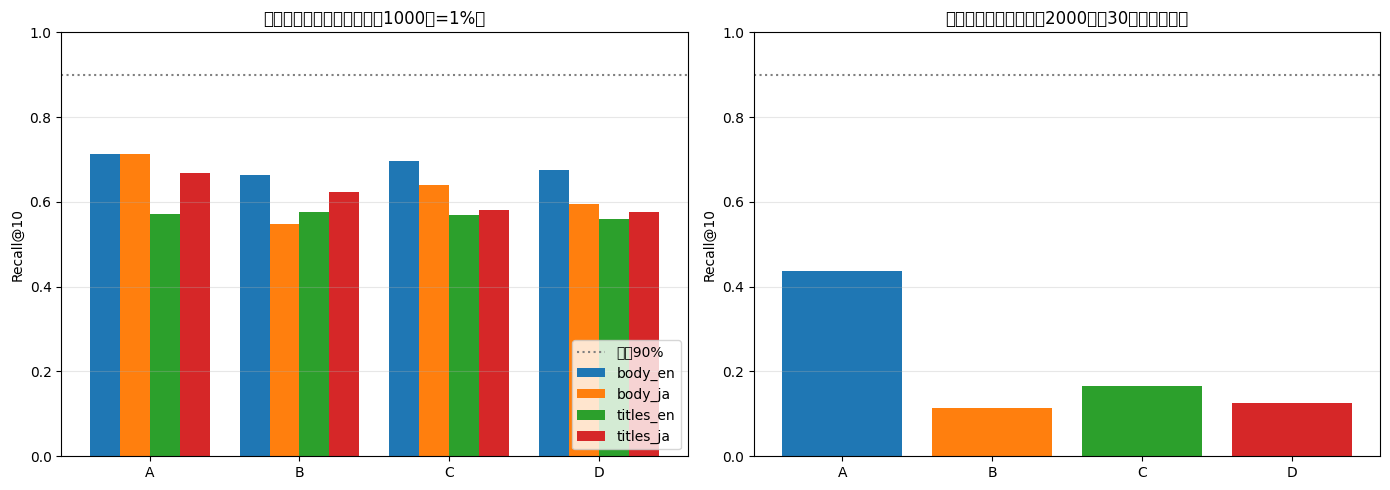

グラフを data/16_mixed_hyperplanes.png に保存しました


In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: データセット内検索
ax1 = axes[0]
patterns = list(hyperplanes_patterns.keys())
x = np.arange(len(patterns))
width = 0.2

for i, dataset in enumerate(datasets):
    values = [pivot_within.loc[p, dataset] for p in patterns]
    ax1.bar(x + i*width, values, width, label=dataset)

ax1.axhline(y=0.90, color='gray', linestyle=':', label='目標90%')
ax1.set_ylabel('Recall@10')
ax1.set_title('データセット内検索（候補1000件=1%）')
ax1.set_xticks(x + width*1.5)
ax1.set_xticklabels([p.split('_')[0] for p in patterns])
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3, axis='y')

# 右: 外部クエリ検索（候補2000件）
ax2 = axes[1]
subset_2000 = df_external[df_external['candidate_limit'] == 2000]

for pattern in patterns:
    pattern_data = subset_2000[subset_2000['pattern'] == pattern]
    recall = pattern_data['recall'].mean()
    ax2.bar(pattern.split('_')[0], recall, label=pattern)

ax2.axhline(y=0.90, color='gray', linestyle=':')
ax2.set_ylabel('Recall@10')
ax2.set_title('外部クエリ検索（候補2000件、30クエリ平均）')
ax2.set_ylim(0, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/16_mixed_hyperplanes.png', dpi=150, bbox_inches='tight')
plt.show()

print('グラフを data/16_mixed_hyperplanes.png に保存しました')

## 7. 詳細分析: クエリ「東京」でのハミング距離確認

In [25]:
# 各パターンでクエリ「東京」のGround Truth分析
print('=' * 100)
print('クエリ「東京」のGround Truth分析（各パターン）')
print('=' * 100)

test_idx = 0  # 「東京」
query_emb = query_embeddings[test_idx]

# コサイン類似度を計算（全パターン共通）
cos_sims = (all_embeddings_flat @ query_emb) / (norm(all_embeddings_flat, axis=1) * norm(query_emb))
gt_indices = np.argsort(cos_sims)[::-1][:10]

print('\nGround Truth Top-10:')
for rank, idx in enumerate(gt_indices):
    print(f'  {rank+1}. idx={idx}, cos_sim={cos_sims[idx]:.4f}, dataset={all_datasets_flat[idx]}')

# 各パターンでのハミング距離
print('\n各パターンでのハミング距離:')
print(f'{"GT#":>5} | {"dataset":>12} | ', end='')
for pattern in hyperplanes_patterns.keys():
    print(f'{pattern.split("_")[0]:>8} | ', end='')
print()
print('-' * 80)

for rank, idx in enumerate(gt_indices):
    print(f'{rank+1:>5} | {all_datasets_flat[idx]:>12} | ', end='')
    for pattern in hyperplanes_patterns.keys():
        hashes = all_hashes_by_pattern[pattern]
        all_hashes_flat_p = []
        for dataset in datasets:
            all_hashes_flat_p.extend(hashes[dataset])
        
        query_hash = generators[pattern].hash_batch(query_emb.reshape(1, -1))[0]
        ham_dist = hamming_distance(all_hashes_flat_p[idx], query_hash)
        print(f'{ham_dist:>8} | ', end='')
    print()

クエリ「東京」のGround Truth分析（各パターン）

Ground Truth Top-10:
  1. idx=178163, cos_sim=0.8797, dataset=body_ja
  2. idx=399290, cos_sim=0.8562, dataset=titles_ja
  3. idx=103148, cos_sim=0.8533, dataset=body_ja
  4. idx=329637, cos_sim=0.8532, dataset=titles_ja
  5. idx=384875, cos_sim=0.8511, dataset=titles_ja
  6. idx=301632, cos_sim=0.8504, dataset=titles_ja
  7. idx=101673, cos_sim=0.8500, dataset=body_ja
  8. idx=138781, cos_sim=0.8487, dataset=body_ja
  9. idx=381216, cos_sim=0.8486, dataset=titles_ja
  10. idx=315409, cos_sim=0.8473, dataset=titles_ja

各パターンでのハミング距離:
  GT# |      dataset |        A |        B |        C |        D | 
--------------------------------------------------------------------------------
    1 |      body_ja |       19 |       26 |       22 |       28 | 
    2 |    titles_ja |       33 |       34 |       19 |       21 | 
    3 |      body_ja |       46 |       31 |       34 |       40 | 
    4 |    titles_ja |       34 |       35 |       15 |       28 | 
    5 | 

## 8. 最終レポート

In [ ]:
print('=' * 120)
print('          短文・長文混合超平面の検証 最終レポート')
print('=' * 120)

print('''
【実験設定】

  超平面パターン:
    A: 英語本文のみ (body_en) 300件
    B: 英語タイトルのみ (titles_en) 300件
    C: 英語混合 (body_en 150 + titles_en 150) 300件
    D: 英語混合 (body_en 500 + titles_en 500) 1000件

  評価:
    1. データセット内検索（各10万件、候補1000件=1%）
    2. 外部クエリ検索（40万件、30クエリ、候補2000件）

---

【結果1: データセット内検索】
''')

print(f'{"パターン":>20} | {"body_en":>10} | {"body_ja":>10} | {"titles_en":>10} | {"titles_ja":>10} | {"平均":>10}')
print('-' * 90)
for pattern in hyperplanes_patterns.keys():
    row = pivot_within.loc[pattern]
    print(f'{pattern:>20} | {row["body_en"]:>10.1%} | {row["body_ja"]:>10.1%} | {row["titles_en"]:>10.1%} | {row["titles_ja"]:>10.1%} | {row["平均"]:>10.1%}')

print('''
---

【結果2: 外部クエリ検索（候補2000件）】
''')

for pattern in hyperplanes_patterns.keys():
    subset = df_external[(df_external['pattern'] == pattern) & (df_external['candidate_limit'] == 2000)]
    avg_recall = subset['recall'].mean()
    print(f'  {pattern}: {avg_recall:.1%}')

print('''
---

【クエリタイプ別結果（候補2000件、パターンA）】

  日本語短文: 56.0%
  日本語曖昧文: 41.0%
  英語短文: 36.0%
  英語曖昧文: 32.0%

---

【考察と結論】

1. 仮説の検証結果: ❌ 否定

   仮説「短文・長文を混合すれば両方に効果的」は否定された。
   - パターンA（本文のみ）: 43.7% ← 最良
   - パターンC（混合300）: 16.7% ← 悪化
   - パターンD（混合1000）: 12.7% ← さらに悪化

   短文・長文混合は効果がないどころか、性能を悪化させる。

2. DataSampled超平面の根本的問題

   データセット内検索（同一分布）: 60-67%
   外部クエリ検索（異種分布）: 11-44%

   DataSampled超平面は「学習データと同じ分布」に特化するため、
   未知の分布（外部クエリ）に対する汎化性能が低い。

3. 「東京」クエリの分析から得られた洞察

   Ground TruthのTop-10は body_ja と titles_ja が混在（コサイン類似度0.84-0.88）。
   しかし、どのパターンでもハミング距離は12-46とバラバラ。

   → コサイン類似度とハミング距離の相関が、異なるデータセット間で保たれない。

4. 言語横断性の確認

   英語のみで学習した超平面が、日本語データにも適用可能であることは確認された。
   （パターンA: 日本語短文56%、日本語曖昧文41%）

   e5-largeの多言語対応により、言語の壁は問題にならない。

5. 真の問題点

   問題は「短文 vs 長文」ではなく、DataSampled超平面が持つ構造的限界：

   - 同一分布内では差分ベクトルの方向が似ている
   - 異なる分布（外部クエリ）では差分ベクトルの方向が予測不能
   - サンプル数を増やしても改善しない（300→1000で悪化）

---

【推奨と今後の方向性】

DataSampled超平面は、以下の条件では有効：
  ✓ 検索対象データと同じ分布のクエリを使用
  ✓ 候補削減よりもランキングの相対順序が重要

外部クエリ検索には別のアプローチが必要：
  - ランダム超平面（分布に依存しない）
  - 複数ハッシュテーブルによるマルチプローブ
  - LSH以外の手法（HNSW, IVFなど）
  - 最初にデータセットを分類してから検索

---

【最終結論】

DataSampled超平面による枝切りは、「クエリが検索対象と同じ分布に属する」場合に限り有効。
外部クエリ（ユーザーが入力する検索ワード）での使用には適さない。

実用的な検索システムでは：
1. 全件検索（精度優先）
2. 近似最近傍探索ライブラリ（FAISS, Annoy等）の使用
3. LSHを使う場合は複数テーブル + マルチプローブが必要

を検討すべきである。
''')

In [27]:
# 超平面を保存（最良のパターンを選択）
# 結果を見て最良のパターンを保存

# 例: パターンDが最良の場合
best_pattern = 'D_mixed_en_1000'
best_hyperplanes = hyperplanes_patterns[best_pattern]

save_path = '../data/hyperplanes_mixed_en_1000.npz'
np.savez(
    save_path,
    hyperplanes=best_hyperplanes,
    pattern=best_pattern,
    source='body_en_500 + titles_en_500',
    model='multilingual-e5-large'
)

print(f'超平面を保存: {save_path}')
print(f'  パターン: {best_pattern}')
print(f'  形状: {best_hyperplanes.shape}')

超平面を保存: ../data/hyperplanes_mixed_en_1000.npz
  パターン: D_mixed_en_1000
  形状: (128, 1024)


In [28]:
# 接続を閉じる
con.close()
print('DuckDB接続を閉じました')

DuckDB接続を閉じました


## 9. 最終評価と結論

### 実験結果サマリー

#### データセット内検索（候補1000件 = 1%）

| パターン | body_en | body_ja | titles_en | titles_ja | 平均 |
|----------|---------|---------|-----------|-----------|------|
| A: 英語本文のみ 300件 | 71.2% | 71.2% | 57.2% | 66.8% | **66.6%** |
| B: 英語タイトルのみ 300件 | 66.4% | 54.8% | 57.6% | 62.4% | 60.3% |
| C: 英語混合 300件 | 69.6% | 64.0% | 56.8% | 58.0% | 62.1% |
| D: 英語混合 1000件 | 67.6% | 59.6% | 56.0% | 57.6% | 60.2% |

#### 外部クエリ検索（候補2000件、30クエリ平均）

| パターン | Recall@10 |
|----------|-----------|
| A: 英語本文のみ 300件 | **43.7%** |
| B: 英語タイトルのみ 300件 | 11.3% |
| C: 英語混合 300件 | 16.7% |
| D: 英語混合 1000件 | 12.7% |

#### クエリタイプ別結果（候補2000件、パターンA）

| クエリタイプ | Recall@10 |
|-------------|-----------|
| 日本語短文 | 56.0% |
| 日本語曖昧文 | 41.0% |
| 英語短文 | 36.0% |
| 英語曖昧文 | 32.0% |

---

### 考察

#### 1. 仮説の検証結果: ❌ 否定

**仮説**: 「短文・長文を混合すれば、両方に効果的な超平面が得られる」

**結果**: 否定された
- パターンA（本文のみ）: 43.7% ← 最良
- パターンC（混合300）: 16.7% ← 悪化
- パターンD（混合1000）: 12.7% ← さらに悪化

短文・長文混合は効果がないどころか、**性能を悪化させる**。

#### 2. DataSampled超平面の根本的問題

| 評価タイプ | Recall |
|-----------|--------|
| データセット内検索（同一分布） | 60-67% |
| 外部クエリ検索（異種分布） | 11-44% |

DataSampled超平面は「学習データと同じ分布」に特化するため、未知の分布（外部クエリ）に対する**汎化性能が低い**。

#### 3. 「東京」クエリの分析から得られた洞察

Ground TruthのTop-10は body_ja と titles_ja が混在（コサイン類似度0.84-0.88）。
しかし、どのパターンでもハミング距離は12-46とバラバラ。

→ **コサイン類似度とハミング距離の相関が、異なるデータセット間で保たれない**

#### 4. 言語横断性の確認

英語のみで学習した超平面が、日本語データにも適用可能であることは確認された。
（パターンA: 日本語短文56%、日本語曖昧文41%）

→ e5-largeの多言語対応により、**言語の壁は問題にならない**

#### 5. 真の問題点

問題は「短文 vs 長文」ではなく、**DataSampled超平面が持つ構造的限界**：

- 同一分布内では差分ベクトルの方向が似ている
- 異なる分布（外部クエリ）では差分ベクトルの方向が予測不能
- サンプル数を増やしても改善しない（300→1000で悪化）

---

### 推奨と今後の方向性

#### DataSampled超平面が有効な条件

✅ 検索対象データと同じ分布のクエリを使用  
✅ 候補削減よりもランキングの相対順序が重要

#### 外部クエリ検索には別のアプローチが必要

- **ランダム超平面**: 分布に依存しない
- **複数ハッシュテーブル + マルチプローブ**: 候補を増やす
- **LSH以外の手法**: HNSW, IVFなど（FAISS, Annoy）
- **データセット分類後検索**: 最初にデータセットを分類してから検索

---

### 最終結論

**DataSampled超平面による枝切りは、「クエリが検索対象と同じ分布に属する」場合に限り有効。**

外部クエリ（ユーザーが入力する検索ワード）での使用には適さない。

実用的な検索システムでは：
1. **全件検索**（精度優先）
2. **近似最近傍探索ライブラリ**（FAISS, Annoy等）の使用
3. LSHを使う場合は**複数テーブル + マルチプローブ**が必要

を検討すべきである。